In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio
from IPython.display import Image
from pathlib import Path
from glob import glob
import pandas as pd
from tqdm import tqdm
import os
from sklearn.metrics import pairwise_distances
from collections import defaultdict
#plt.rcParams.update({'font.size': 40})

In [2]:
def show(puzzle, label='', force_zeros=False):
    plt.imshow(puzzle, cmap='Set1')
    plt.axis('off')
    if type(label) == list:
        label = ' '.join(label)
    plt.title(label)
    for (j,i),label in np.ndenumerate(puzzle):
        if not force_zeros:
            if label == 0:continue
        plt.text(i,j,f"{label:0.3f}",ha='center',va='center', fontsize=20)


def show_policy(puzzle, label=''):
    id2char = ['L', 'U', 'R', 'D']
    
    plt.imshow(puzzle, cmap='Set1')
    plt.axis('off')
    if type(label) == list:
        label = ' '.join(label)
    plt.title(label)
    for (j,i),label in np.ndenumerate(puzzle):
        plt.text(i,j,id2char[label],ha='center',va='center', fontsize=20)
        
def show_all(utility, policy, end_states, label='', force_zeros=True, cbar=False):
    id2char = ['L', 'U', 'R', 'D', '*']
    plt.figure(figsize=(12, 4))
    plt.suptitle(label)
    plt.subplot(121);plt.axis('off')
    plt.imshow(utility, cmap='Set1')
    if cbar:plt.colorbar()
    for (j,i),label in np.ndenumerate(utility):
        if not force_zeros:
            if label == 0:continue
        plt.text(i,j,f"{label:0.3f}",ha='center',va='center', fontsize=18)

    plt.subplot(122);plt.axis('off')
    plt.imshow(policy, cmap='Set1')
    for (j,i),label in np.ndenumerate(policy):
        if [j, i] in end_states:label = -1
        plt.text(i,j,id2char[label],ha='center',va='center', fontsize=26)
    

def get_puzzle(r):
    field   = np.ones((3,4)) * r
    value   = np.zeros((3,4))
    field[0, 3] =    1
    field[1, 3] =   -1
    field[2, 3] =  0.2
    field[1, 1] = -0.5
    start = [2, 0]
    ends  = [[0, 3], [1, 3]]
    return field, value, start, ends

def get_reward_pos(puzzle, pos):
    return puzzle[pos[0], pos[1]]

def get_reward(puzzle, path):
    reward = 0
    for pos in path:
        reward += get_reward_pos(puzzle, pos)
    return reward

def check_in(puzzle, pos):
    h, w, *_ = puzzle.shape
    return (pos[0] < h) and (pos[1] < w) and (pos[0] >= 0) and (pos[1] >= 0)


def rotate(delta, val=0):
    pos_val = [[0,-1], [-1,0], [0,1], [1,0]]
    curr    = pos_val.index(delta)
    return pos_val[(curr+val) % len(pos_val)]
    
    
def step(puzzle, start, delta):
    # delta: [0,+1], [0,-1], [+1,0], [-1,0], 
    end_pos = start
    
    rnd = np.random.rand()
    if rnd > 0.9:
        delta = rotate(delta, 1)
    
    if rnd < 0.1:
        delta = rotate(delta, -1)
    
    end_pos = [start[0] + delta[0], start[1] + delta[1]]
    return end_pos if check_in(puzzle, end_pos) else start
    
def add_prob(puzzle, probs, pos, idx, inc):
    if check_in(puzzle, pos):
        probs[idx] += inc
    else:
        probs[-1]  += inc
        
def get_prob(puzzle, start, delta):
    probs     = [0,0,0,0] # left, forward, right, stay
    
    deltal    = rotate(delta, -1)
    end_pos_l = [start[0] + deltal[0], start[1] + deltal[1]]
    add_prob(puzzle, probs, end_pos_l, 0, 0.1) # left 0
    
    deltar    = rotate(delta,  1)
    end_pos_r = [start[0] + deltar[0], start[1] + deltar[1]]
    add_prob(puzzle, probs, end_pos_r, 2, 0.1) # right 2
    
    end_pos   = [start[0] + delta[0], start[1] + delta[1]]
    add_prob(puzzle, probs, end_pos, 1, 0.8) # right 2
    
    ends = [end_pos_l, end_pos, end_pos_r, start]
    
    assert sum(probs)== 1.0
    return probs,ends

In [3]:
def get_pos_utility(utility, end_states, pos):
    if pos in end_states:
        return 0, 0
    
    final_r = []
    for delta in [[0,-1], [-1,0], [0,1], [1,0]]:
        probs, ends = get_prob(utility, pos, delta)
        rewards = list(map(lambda end: get_reward_pos(utility, end) if check_in(utility, end) else 0, ends))
        final_r.append((rewards * np.array(probs)).sum())
    
    id_max = np.argmax(final_r)

    return final_r[id_max], id_max

def update_utility(puzzle, utility, end_states, gamma=0.5):
    h, w, *_ = utility.shape
    policy = np.zeros_like(puzzle).astype(int)
    for idy in range(h):
        for idx in range(w):
            u, amax = get_pos_utility(utility, end_states, [idy, idx])
            utility[idy, idx] = puzzle[idy, idx] + (gamma * u)
            policy[idy, idx]  = amax
    return utility, policy

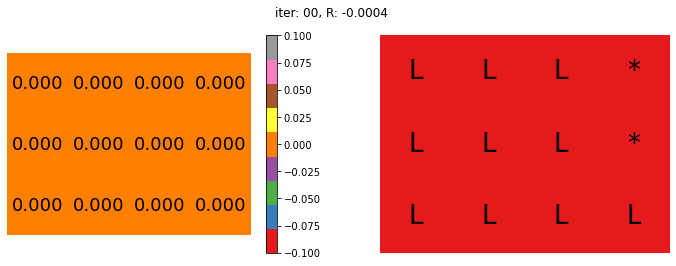

In [14]:
r = -0.0004
gamma = 0.7
puzzle, utility, start, end_states = get_puzzle(r)
policy = np.zeros_like(puzzle, dtype=int)
show_all(utility, policy, end_states, 
             label=f"iter: {0:02d}, R: {r}", cbar=True)
#plt.savefig(f"extra/map_{r}.jpg")

In [15]:
#puzzle_view = [cv2.imread(url)[..., ::-1] for url in sorted(glob(save_path+'/*.jpg'))]
save_path = fr'extra/{r}_{gamma}'
Path(save_path).mkdir(exist_ok=True)
save_path_gif = fr'{save_path}/summary.gif'

utility_list = []

for idx in range(20):
    show_all(utility, policy, end_states, 
             label=f"iter: {idx:02d}, R: {r}, Gamma: {gamma}", cbar=True)
    
    utility_list.append(utility.copy())
    plt.savefig(save_path+f'/{idx+1:03d}.jpg')
    plt.close()
    
    utility, policy = update_utility(puzzle, utility, end_states, gamma=gamma)

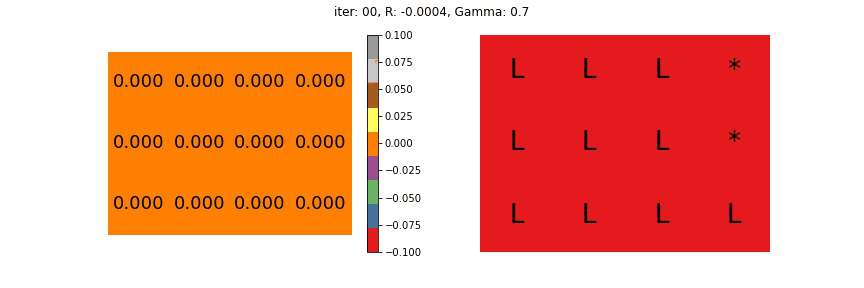

In [16]:
imgs_list = [cv2.imread(url)[..., ::-1] for url in sorted(glob(save_path + '/*.jpg'))]

imageio.mimsave(save_path_gif, imgs_list, fps=1)
        
with open(save_path_gif, 'rb') as f:
    display(Image(data=f.read(), format='png'))
